# Decoy State QKD Protocol Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import math
from ThOPqkdsim.simDecoyState import *

<div style="text-align: center;">
    <img src="Figures/Decoy_State/decoystatefig.png" width="800">
</div>

## <a name="introduction"></a>1. Introduction: Quantum Key Distribution (QKD)

**Quantum Key Distribution (QKD)** is a secure communication method which enables two parties (typically called Alice and Bob) to generate a shared, secret random key, which can be used for encrypting and decrypting messages. The security of QKD is based on the fundamental laws of quantum mechanics.


## <a name="decoy-state-background"></a>2. Decoy State QKD: Principles & Background

- **BB84 Protocol**: The first QKD protocol, which uses quantum states to encode bits.
- **Decoy State Method**: Enhances security and key rate by sending signal and decoy pulses of different intensities, thwarting photon-number-splitting (PNS) attacks.

Key concepts:
- **Signal state (`mu`)**: Mean photon number for the main signal pulse.
- **Decoy states (`nu1`, `nu2`)**: Lower-intensity pulses used to estimate channel parameters and detect eavesdropping.

---

<div style="text-align: center;">
    <img src="Figures/Decoy_State/QKD_sim-Decoy State qkd steps.png" width="800">
</div>

## <a name="decoystateqkd-class"></a>3. Simulator: The `DecoyStateQKD` Class

We now provide a class-based simulator for decoy-state QKD, with detailed explanations for each section.

### <a name="init-params"></a>Class Initialization & Parameters

- `wavelength`: The wavelength of the photons (nm), typically 1550 nm for minimal fiber loss.
- `alpha`: Fiber attenuation coefficient (dB/km), determines how much light is lost per km.
- `e_detector`: Probability that a detected photon is erroneous (e.g., due to misalignment or dark counts).
- `Y0`: Background count rate (probability of a click when no photon sent).
- `eta_bob`: Overall efficiency at Bob's side (product of Bob's optics and detector efficiency).
- `mu`: Signal state mean photon number (the average photons per pulse in signal).
- `nu1`, `nu2`: Decoy state mean photon numbers (typically, `nu2` is vacuum, i.e., 0).
- `f`: Error correction efficiency (relative to Shannon limit, >1).
- `q`: Protocol efficiency (1/2 for BB84, due to basis sifting).
- `rep_rate`: Pulse repetition rate (Hz).

---

In [2]:
class DecoystateqKD:
    def __init__(self, 
                 wavelength=1550,  # nm
                 alpha=0.21,       # dB/km (fiber loss coefficient)
                 e_detector=0.033, # detector error probability (3.3%)
                 Y0=1.7e-6,       # background rate
                 eta_bob=0.045,    # Bob's side efficiency (internal transmittance * detector efficiency)
                 mu=0.5,           # signal state intensity
                 nu1=0.1,          # decoy state 1 intensity
                 nu2=0.0,          # decoy state 2 intensity (vacuum)
                 f=1.22,           # error correction efficiency
                 q=0.5,            # protocol efficiency factor (1/2 for BB84)
                 rep_rate=2e6      # repetition rate in Hz (2 MHz as default from Table 1)
                ):
        self.wavelength = wavelength
        self.alpha = alpha
        self.e_detector = e_detector
        self.Y0 = Y0
        self.eta_bob = eta_bob
        self.mu = mu
        self.nu1 = nu1
        self.nu2 = nu2
        self.f = f
        self.q = q
        self.rep_rate = rep_rate
        self.e0 = 0.5  # error rate of background (random)

### <a name="transmittance"></a>Transmittance Models

**Channel transmittance** quantifies the probability of a photon reaching Bob.
- `calculate_channel_transmittance`: Models fiber loss as exponential decay.
- `calculate_total_transmittance`: Multiplies channel transmission by Bob's overall detection efficiency.


### Channel Loss: $\alpha$

- $\alpha$: Loss coefficient of optical fiber (dB/km).
- Channel transmittance over distance $L$:

$
t_{AB} = 10^{-\frac{\alpha L}{10}}
$

### Detector Parameters

- $e_{detector}$: Probability an incoming photon is measured in the wrong basis (detector error).
- $Y_0$: Background (dark count) rate of Bob's detector.
- $\eta_{bob}$: Total efficiency on Bob's side (internal losses × detector efficiency).

**Total transmittance:**

$
\eta = t_{AB} \cdot \eta_{bob}
$

---

In [3]:
def calculate_channel_transmittance(self, distance):
        """Calculate channel transmittance based on distance and loss coefficient"""
        t_AB = 10 ** (-(self.alpha * distance) / 10)
        return t_AB
    
def calculate_total_transmittance(self, distance):
    """Calculate total transmittance including Bob's efficiency"""
    t_AB = self.calculate_channel_transmittance(distance)
    eta = t_AB * self.eta_bob
    return eta

### <a name="yields-errors"></a>Photon State Yields and Errors

**Yield (`Y_i`)**: Probability that an i-photon pulse causes a detection.

**Error rate (`e_i`)**: Probability that an i-photon pulse is detected incorrectly.
- `yield_i_photon`: Combines background and signal contributions.
- `error_i_photon`: Weighted sum of error contributions from dark counts and detector errors.

#### Yields and Errors

- **Yield**: Probability that a pulse with $i$ photons produces a click at Bob.

$
Y_i = Y_0 + \eta_i - Y_0 \eta_i \approx Y_0 + \eta_i
$
where $\eta_i = 1 - (1-\eta)^i$

- **Error rate for i-photon state**:
$
e_i = \frac{e_0 Y_0 + e_{detector} \eta_i}{Y_i}
$


---

In [4]:
def yield_i_photon(self, i, eta):
        """Calculate yield for i-photon state"""
        eta_i = 1 - (1 - eta) ** i
        Y_i = self.Y0 + eta_i - self.Y0 * eta_i
        return Y_i
    
def error_i_photon(self, i, eta):
    """Calculate error rate for i-photon state"""
    Y_i = self.yield_i_photon(i, eta)
    eta_i = 1 - (1 - eta) ** i
    e_i = (self.e0 * self.Y0 + self.e_detector * eta_i) / Y_i
    return e_i
    

### <a name="gain-qber"></a>Gain and QBER Calculations

- **Gain (`Q`)**: Probability that Bob registers a click per pulse.
- **QBER**: Quantum Bit Error Rate (fraction of erroneous bits).

#### Gain

- **Gain for i-photon state**:
$
Q_i = Y_i \frac{\mu^i}{i!} e^{-\mu}
$

- **Overall gain**:
$
Q_\mu = Y_0 + 1 - e^{-\eta \mu}
$

#### QBER

- **Overall QBER**:
$
E_\mu Q_\mu = e_0 Y_0 + e_{detector}(1 - e^{-\eta \mu})
$
$
E_\mu = \frac{E_\mu Q_\mu}{Q_\mu}
$


---

In [5]:
def gain_i_photon(self, i, mu, eta):
    """Calculate gain for i-photon state"""

    Y_i = self.yield_i_photon(i, eta)
    Q_i = Y_i * (mu ** i / np.math.factorial(i)) * np.exp(-mu)
    return Q_i

def overall_gain(self, mu, eta):
    """Calculate overall gain"""
    Q_mu = self.Y0 + (1 - np.exp(-eta * mu))
    return Q_mu

def overall_QBER(self, mu, eta):
        """Calculate overall QBER"""
        Q_mu = self.overall_gain(mu, eta)
        E_mu_Q_mu = self.e0 * self.Y0 + self.e_detector * (1 - np.exp(-eta * mu))
        E_mu = E_mu_Q_mu / Q_mu
        return E_mu

### <a name="decoy-estimation"></a>Decoy Parameter Estimation

Estimates for the single-photon yield (`Y1_L`), background (`Y0_L`), single-photon error (`e1_U`), and gain (`Q1_L`) using **decoy state analysis**.

### Decoy State Estimation (Lower/Upper Bounds)

- **Lower bound for $Y_0$** (Eq. 18):

$
Y_0^L = \frac{\nu_1 Q_{\nu_2} e^{\nu_2} - \nu_2 Q_{\nu_1} e^{\nu_1}}{\nu_1 - \nu_2}
$

- **Lower bound for $Y_1\)** (Eq. 21):

$
Y_1^L = \frac{\mu}{\mu \nu_1 - \mu \nu_2 - \nu_1^2 + \nu_2^2} \left[ Q_{\nu_1} e^{\nu_1} - Q_{\nu_2} e^{\nu_2} - \frac{\nu_1^2 - \nu_2^2}{\mu^2} (Q_\mu e^{\mu} - Y_0^L) \right]
$

- **Lower bound for single-photon gain:**
$
Q_1^L = Y_1^L \mu e^{-\mu}
$

- **Upper bound for single-photon error:**
$
e_1^U = \frac{E_{\nu_1} Q_{\nu_1} e^{\nu_1} - E_{\nu_2} Q_{\nu_2} e^{\nu_2}}
{(\nu_1 - \nu_2) Y_1^L}
$


---

In [6]:
def estimate_Y0_lower_bound(self, Q_nu1, Q_nu2):
    """Estimate lower bound of Y0 using Equation (18)"""
    Y0_L = max((self.nu1 * Q_nu2 * np.exp(self.nu2) - self.nu2 * Q_nu1 * np.exp(self.nu1)) / 
                (self.nu1 - self.nu2), 0)
    return Y0_L

def estimate_Y1_lower_bound(self, Q_mu, Q_nu1, Q_nu2, Y0_L):
    """Estimate lower bound of Y1 using Equation (21)"""
    numerator = Q_nu1 * np.exp(self.nu1) - Q_nu2 * np.exp(self.nu2) - \
                ((self.nu1**2 - self.nu2**2) / self.mu**2) * (Q_mu * np.exp(self.mu) - Y0_L)
    denominator = self.mu * self.nu1 - self.mu * self.nu2 - self.nu1**2 + self.nu2**2
    
    # Handle division by zero
    if abs(denominator) < 1e-10:
        denominator = 1e-10 if denominator >= 0 else -1e-10
        
    Y1_L = (self.mu / denominator) * numerator
    return Y1_L

def estimate_Q1_lower_bound(self, Q_mu, Q_nu1, Q_nu2, Y0_L):
    """Estimate lower bound of Q1 using Equation (22)"""
    Y1_L = self.estimate_Y1_lower_bound(Q_mu, Q_nu1, Q_nu2, Y0_L)
    Q1_L = Y1_L * self.mu * np.exp(-self.mu)
    return Q1_L

def estimate_e1_upper_bound(self, Q_nu1, Q_nu2, E_nu1, E_nu2, Y1_L):
    """Estimate upper bound of e1 using Equation (25)"""
    # Check for division by zero in individual terms
    nu_diff = self.nu1 - self.nu2
    if abs(nu_diff) < 1e-10:
        nu_diff = 1e-10 if nu_diff >= 0 else -1e-10
        
    # Ensure Y1_L is not zero
    if abs(Y1_L) < 1e-10:
        Y1_L = 1e-10
        
    e1_U = (E_nu1 * Q_nu1 * np.exp(self.nu1) - E_nu2 * Q_nu2 * np.exp(self.nu2)) / \
        (nu_diff * Y1_L)
    return e1_U

### <a name="key-rate"></a>Key Rate Calculation

**Secure key rate** formula (per second), based on decoy-state analysis.

#### Secure Key Rate

- **Binary entropy:**
$
H_2(x) = -x\log_2 x - (1-x)\log_2(1-x)
$

- **Secure key rate per pulse:**
$
R = q \left[ -Q_\mu f H_2(E_\mu) + Q_1^L (1 - H_2(e_1^U)) \right]
$
- **Convert to bits/sec:**
$
R_{bps} = R \times \text{rep\_rate}
$

In [7]:
def key_rate(self, distance):
    """Calculate secure key rate using Equation (26)"""
    eta = self.calculate_total_transmittance(distance)
    
    # Calculate the gains and QBERs for signal and decoy states
    Q_mu = self.overall_gain(self.mu, eta)
    Q_nu1 = self.overall_gain(self.nu1, eta)
    Q_nu2 = self.overall_gain(self.nu2, eta)
    
    E_mu = self.overall_QBER(self.mu, eta)
    E_nu1 = self.overall_QBER(self.nu1, eta)
    E_nu2 = self.overall_QBER(self.nu2, eta)
    
    # Estimate parameters using decoy state method
    Y0_L = self.estimate_Y0_lower_bound(Q_nu1, Q_nu2)
    Y1_L = self.estimate_Y1_lower_bound(Q_mu, Q_nu1, Q_nu2, Y0_L)
    Q1_L = self.estimate_Q1_lower_bound(Q_mu, Q_nu1, Q_nu2, Y0_L)
    e1_U = self.estimate_e1_upper_bound(Q_nu1, Q_nu2, E_nu1, E_nu2, Y1_L)
    
    # Shannon entropy
    def H2(x):
        """Calculate binary Shannon entropy with safety checks for numerical stability"""
        # Handle values outside [0,1] range by clamping
        if x <= 0 or x >= 1:
            return 0
        
        # Additional protection for values extremely close to 0 or 1
        epsilon = 1e-15  # Small value to prevent log(0)
        x = max(min(x, 1-epsilon), epsilon)

        return -x * np.log2(x) - (1-x) * np.log2(1-x)
    
    # Calculate secure key rate using Equation (1)
    R_per_pulse = self.q * (-Q_mu * self.f * H2(E_mu) + Q1_L * (1 - H2(e1_U)))
    R_per_second = R_per_pulse * self.rep_rate
    
    return max(0, R_per_second), E_mu, Q_mu, Y1_L, e1_U, Q1_L

## QBER calculation

<div style="text-align: center;">
    <img src="Figures/Decoy_State/QKD_sim-decoystateqkd-qber.png" width="800">
</div>

## SKR calculation

<div style="text-align: center;">
    <img src="Figures/Decoy_State/QKD_sim-decoystateqkd-skr (1).png" width="500">
</div>

<a id='section4'></a>
## 4. Simulator Demo: Exploring QKD Performance

Let's analyze and visualize how different system parameters affect secure key rate and QBER.

In [8]:
def run_decoy_state_qkd_simulation():
    """Main function to demonstrate the QKD simulator"""
    # Define simulation parameters
    params = {
        'wavelength': 1550,     # nm
        'alpha': 0.21,          # dB/km
        'e_detector': 0.033,    # detector error probability (3.3%)
        'Y0': 1.7e-6,           # background rate
        'eta_bob': 0.045,       # Bob's side efficiency
        'mu': 0.5,              # signal state intensity
        'nu1': 0.1,             # decoy state 1 intensity
        'nu2': 0.0,             # decoy state 2 intensity (vacuum)
        'f': 1.22,              # error correction efficiency
        'q': 0.5,               # protocol efficiency factor (1/2 for BB84)
        'rep_rate': 1e6         # repetition rate in Hz 
    }
    
    # Create QKD simulator with specified parameters
    qkd = DecoyStateQKD(**params)
    
    # Example of calculating key rate at specific distance
    distance = 50  # km
    rate, qber, gain, Y1_L, e1_U, Q1_L = qkd.key_rate(distance)
    print(f"Key Rate at {distance} km: {rate:.2f} bits/s")
    print(f"QBER at {distance} km: {qber*100:.2f}%")
    
    # Generate plots
    
    
    plot_qber_vs_mu(qkd, distance=50)
    plot_qber_vs_distance(qkd)
    plot_key_rate_vs_distance(qkd)
    plot_key_rate_vs_mu(qkd, distance=50)
    plot_key_rate_vs_error(qkd, distance=50)
    
    # Example of parameter optimization
    print("\nFinding optimal signal state intensity...")
    mu_values, mu_key_rates, _ = analyze_mu_dependence(qkd, distance=50)
    optimal_idx = np.argmax(mu_key_rates)
    print(f"Optimal μ at 50 km: {mu_values[optimal_idx]:.2f}")
    print(f"Optimal key rate: {mu_key_rates[optimal_idx]:.2f} bits/s")


Key Rate at 50 km: 194.58 bits/s
QBER at 50 km: 3.34%


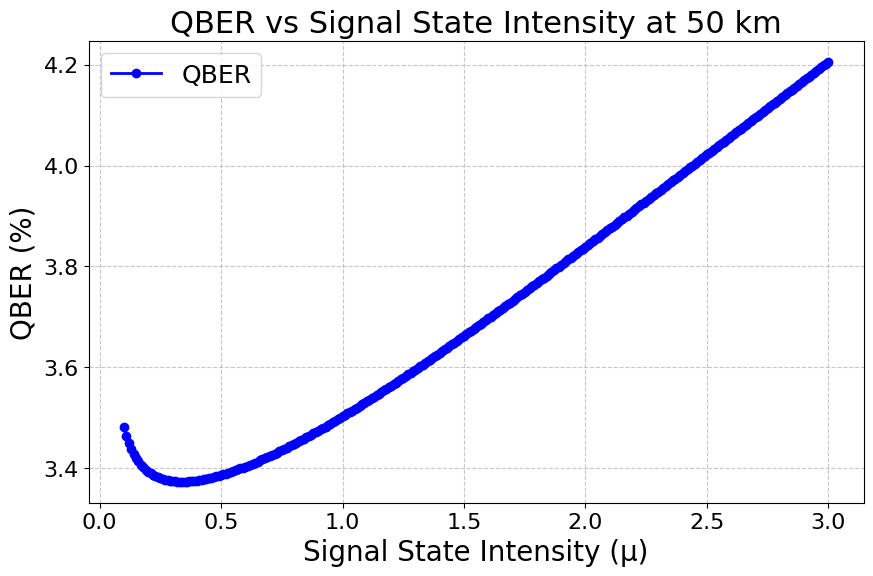

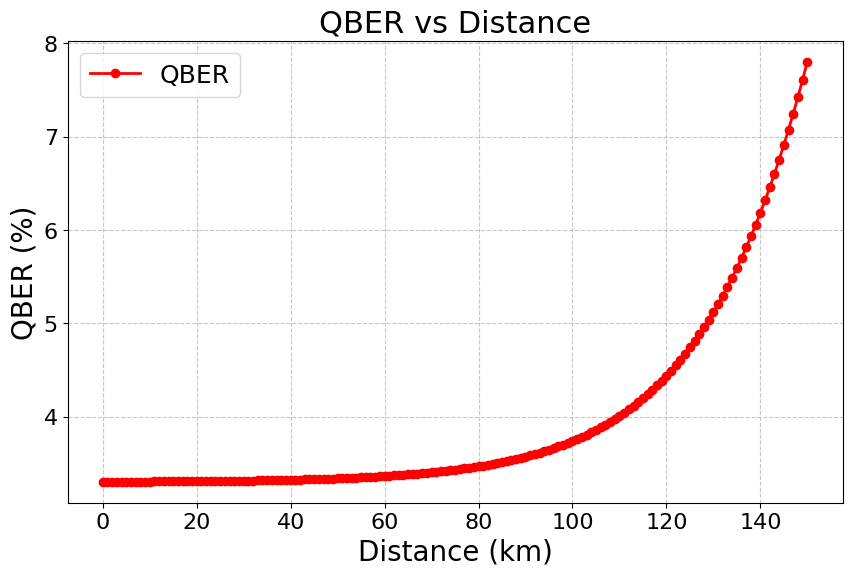

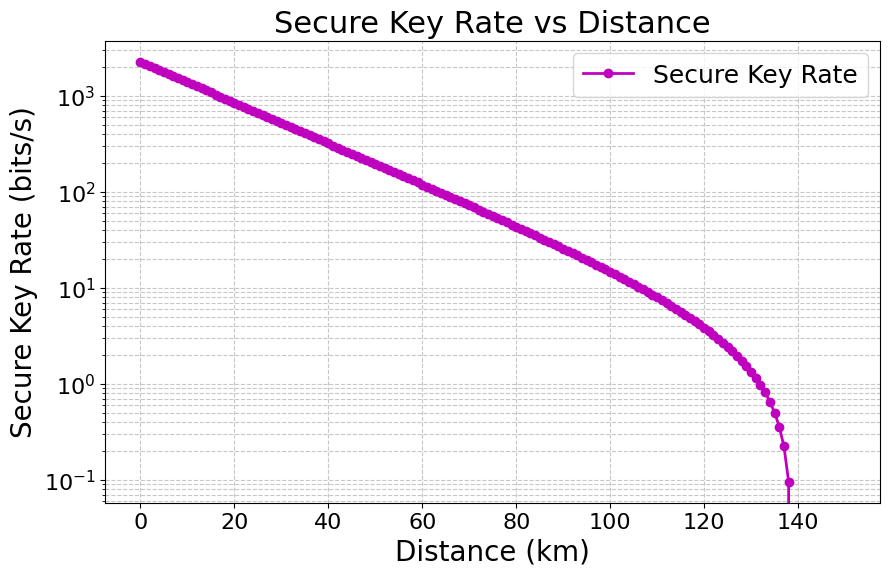

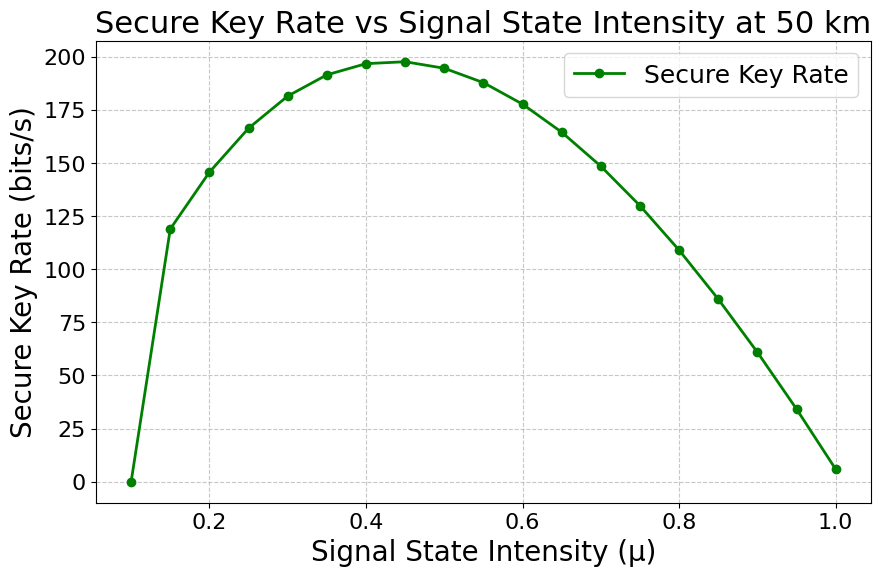

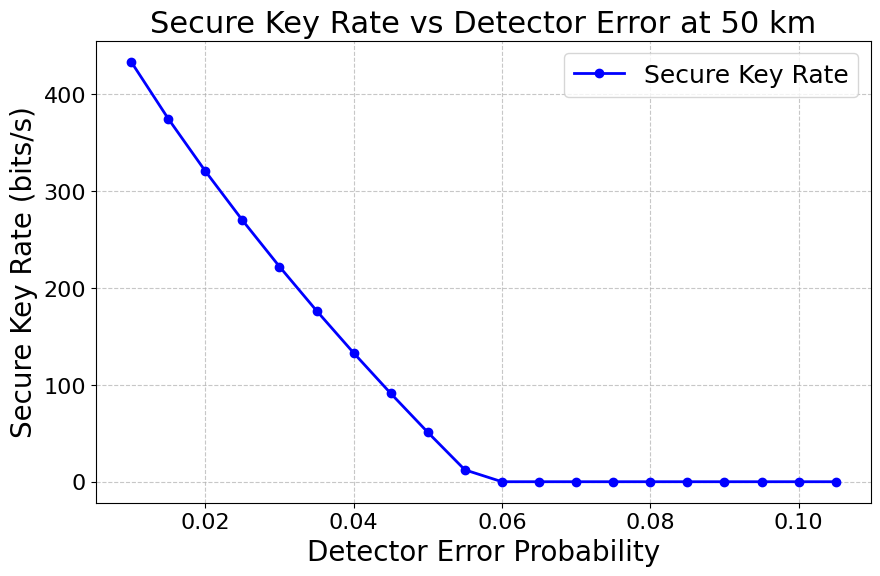


Finding optimal signal state intensity...
Optimal μ at 50 km: 0.45
Optimal key rate: 197.67 bits/s


In [9]:
run_decoy_state_qkd_simulation()

## 5. Conclusion and Future Work

### Conclusion

In this module, we developed and analyzed a comprehensive Decoy State BB84 Quantum Key Distribution (QKD) simulator. By methodically exploring the effects of fiber attenuation, detector imperfections, and protocol parameters

Key takeaways include:
- The secure key rate drops exponentially with channel distance, primarily due to fiber loss and increased relative impact of detector dark counts.
- An optimal signal intensity (\(\mu\)) exists that maximizes the key rate for a given distance, balancing between higher signal detection probability and increased vulnerability to multi-photon attacks.
- Detector error and dark count rates significantly impact both key rate and QBER, especially at long distances.
- The decoy-state method allows rigorous estimation of single-photon contributions, ensuring security against advanced eavesdropping strategies.

### Future Work

While this simulator provides a solid foundation for studying decoy-state BB84 QKD, several avenues for further exploration and enhancement remain:

1. **Finite-Key Effects:**  
   Incorporate finite-size statistical effects, rather than assuming an infinite number of signals, to more accurately reflect real experimental scenarios.

2. **More Realistic Error Models:**  
   Extend the error model to include misalignment errors, afterpulsing, and time-dependent effects.

3. **Additional Protocols:**  
   Expand the simulator to include other QKD protocols such as Measurement-Device-Independent (MDI) QKD or Continuous-Variable (CV) QKD.

4. **Optimization Tools:**  
   Implement automatic parameter optimization routines to find ideal settings (\(\mu\), \(\nu_1\), \(\nu_2\), etc.) for specific experimental setups or requirements.

5. **Security Analysis Enhancements:**  
   Integrate composable security proof frameworks and advanced statistical tools for even more rigorous analysis of security bounds.

6. **Visualization and Interactivity:**  
   Build interactive widgets (using, e.g., ipywidgets) for real-time parameter adjustment and immediate feedback in Jupyter notebooks.

7. **Experimental Data Integration:**  
   Allow users to input real experimental data to validate the theoretical model and analyze real-world system performance.

---